# 単語分散表現

単語分散表現とは、単語の意味を低次元の実数値ベクトルで表現することです。

機械学習・深層学習モデルは、ベクトル（数値の配列）を入力として受け取ります。テキストを扱う際、最初に決めなければならないのは、文字列を機械学習モデルに入力する前に、数値に変換する（あるいはテキストを「ベクトル化」する）ための戦略です。

単語の持つ性質や意味をよく反映するベクトル表現を獲得することは、機械学習・深層学習を自然言語処理で活用するために重要なプロセスです。

- 類似性: ある概念を表現する際に、ほかの概念との共通点や類似性と紐づけながら、ベクトル空間上に表現します。
- 単語類推: 分散表現では異なる概念を表現するベクトル同士での計算が可能です


```{figure} ./Figure/word2vec.png
---
align: center
width: 600px
---
- 単語分散表現による単語の意味の類似性を表現することができます: 意味的に近い単語（例：cat と kitten）は近い位置に配置されます
- 単語分散表現による単語類推を行うことができます: man と woman、king と queen のように意味的に対応関係を持つ単語はベクトル差が似た方向を持つため、アナロジー推論（king - man + woman ≈ queen）が可能になります
```


```{figure} ./Figure/city.png
---
align: center
width: 600px
---
- 単語分散表現による多次元ベクトル空間において意味や関係を捉えます: 
```

単語ベクトルへの変換には様々なアプローチが存在します。最初は、(1)統計情報から単語を表現する手法ーカウントベースの手法ーについて説明します。この方法は、言語のモデル化を理解することに役に立つと考られます。そして、(2)ニューラルネットワークを用いた手法(具体的には、word2vecと呼ばれる手法)を扱います。


1. カウントベースの手法
    - 統計情報から単語を表現する手法
2. 推論ベースの手法
    - ニューラルネットワークを用いた手法

## シソーラスによる手法

「単語の意味」を表すためには、人の手によって単語の意味を定義することが考えられます。

シソーラス(thesaurus)と呼ばれるタイプの辞書は、単語間の関係を異表記・類義語・上位下位といった関係性を用いて、単語間の関連を定義できます。

$$
car = auto \ automobile \ machine \ motorcar
$$

![](./Figure/thesaurus.png)


この「単語ネットーワーク」を利用することで、コンピュータに単語間の関連性を伝えることができます。しかし、この手法には大きな欠点が存在します。

- 人の作業コストが高い
- 時代の変化に対応するのが困難
    - 言語は常に進化しており、新しい単語や意味が生まれては消えていくので、シソーラスを最新の状態に保つのは難しいです。
- 単語の些細なかニュアンスを表現できない
    - 単語が持つ複数の意味を区別することは難しい
    - 単語間の関連性はシソーラスでは静的なものであり、動的な文脈や知識の流れを反映しきれないことがあります

## カウントベースの手法

コーパスには、自然言語に対する人の「知識」ー文章の書き方、単語の選び方、単語の意味ーがふんだんに含まれています。カウントベースの手法の目標は、そのような人の知識が詰まったコーパスから自動的に抽出することにあります。

### コーパスの前処理

コーパスに対して、テキストデータを単語に分割し、その分割した単語をID化にすることが必要されます。

単語のID化とは、テキストデータを機械学習モデルなどで処理する際に、単語を一意の整数値（ID）に変換するプロセスを指します。これは、テキストデータをベクトルや行列の形でモデルに入力するための前処理として行われます。


例として、簡単なテキストを用意します。

In [7]:
text = 'You say goodbye and I say hello.'

In [8]:
# 小文字に変換
text = text.lower()
print(text)

# ピリオドの前にスペースを挿入
text = text.replace('.', ' .')
print(text)

# 単語ごとに分割
words = text.split(' ')
print(words)

you say goodbye and i say hello.
you say goodbye and i say hello .
['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


これで、元の文章を単語リストとして利用できるようになりました。これに基づいて、分割した単語と、単語ごとに通し番号を割り振ったIDを2つのディクショナリに格納します。

In [9]:
# ディクショナリを初期化
word_to_id = {}
id_to_word = {}

# 未収録の単語をディクショナリに格納
for word in words:
    if word not in word_to_id: # 未収録の単語のとき
        # 次の単語のidを取得
        new_id = len(word_to_id)
        
        # 単語IDを格納
        word_to_id[word] = new_id
        
        # 単語を格納
        id_to_word[new_id] = word

In [10]:
# 単語IDを指定すると単語を返す
print(id_to_word)
print(id_to_word[5])

# 単語を指定すると単語IDを返す
print(word_to_id)
print(word_to_id['hello'])

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
hello
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
5


最後に、単語リストから単語IDリストに変換します。

In [11]:
import numpy as np
# リストに変換
corpus = [word_to_id[word] for word in words]

# NumPy配列に変換
corpus = np.array(corpus)
print(corpus)

[0 1 2 3 4 1 5 6]


以上の処理を```preprocess()```という関数として、まとめて実装することにします。

In [12]:
# 前処理関数の実装
def preprocess(text):
    # 前処理
    text = text.lower() # 小文字に変換
    text = text.replace('.', ' .') # ピリオドの前にスペースを挿入
    words = text.split(' ') # 単語ごとに分割
    
    # ディクショナリを初期化
    word_to_id = {}
    id_to_word = {}
    
    # 未収録の単語をディクショナリに格納
    for word in words:
        if word not in word_to_id: # 未収録の単語のとき
            # 次の単語のidを取得
            new_id = len(word_to_id)
            
            # 単語をキーとして単語IDを格納
            word_to_id[word] = new_id
            
            # 単語IDをキーとして単語を格納
            id_to_word[new_id] = word
    
    # 単語IDリストを作成
    corpus = [word_to_id[w] for w in words]
    
    return corpus, word_to_id, id_to_word

In [13]:
# テキストを設定
text = 'You say goodbye and I say hello.'

# 単語と単語IDに関する変数を取得
corpus, word_to_id, id_to_word = preprocess(text)
print(id_to_word)
print(word_to_id)
print(corpus)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
[0, 1, 2, 3, 4, 1, 5, 6]


### 分布仮説

分布仮説（Distributional Hypothesis）は、言語学や自然言語処理の分野で重要な考え方で、単語の意味は、周囲の単語(コンテキスト)によって形成されるというものです。

- 単語は、その単語が出現する文脈の集合によって意味が形成されるとされます。同じ文脈で出現する単語は、意味が似ていると考えられます。
- 単語Aと単語Bが多くの共通の文脈で使用される場合、これらの単語は意味的に関連があると見なされます。

この仮説は、単語の意味を捉えるためのモデルを作成する際に基本的な原則となっています。

![](./Figure/DH.png)

### 共起行列

分布仮説に基づいた単語ベクトル化の方法を考える際、一番素直な方法は、周囲の単語を"カウント"することです。つまり、ある単語に着目した場合、その周囲どのような単語がどれだけ現れるのかをカウントし、それを集計するのです。

ここでは、"*You say goodbye and I say hello.*"という文章について、ウィンドウサイズを$1$とする場合、そのコンテキストに含まれる単語の頻度をカウントしてみます。

```{figure} ./Figure/co-occur.png
---
align: center
---
各単語について、そのコンテキストに含まれす単語の頻度
```


- 「You」の周辺単語は「say」のみであり、「say」にのみコンテキストの目印として共起した回数の$1$をカウントします
- 「say」については文字列中に2回現れていることに注意すると、$[1, 0, 1, 0, 1, 1, 0]$とベクトル表記できます

全ての単語に対して、共起する単語をまとめたものを共起行列と呼ばれます。

In [14]:
# ウィンドウサイズを指定
wndow_size = 1

# 単語の種類数を取得
vocab_size = len(word_to_id)
print(f"単語の種類数: {vocab_size}")

# 総単語数を取得
corpus_size = len(corpus)
print(f"総単語数: {corpus_size}")

単語の種類数: 7
総単語数: 8


In [15]:
# 共起行列を初期化
co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
print(co_matrix)
print(co_matrix.shape)

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
(7, 7)


コーパスの7語目の単語「hello」に注目してみます。

In [16]:
# 単語インデックスを指定
idx = 6

# 指定した単語のIDを取得
word_id = corpus[idx]
print(word_id)
print(id_to_word[word_id])

5
hello


In [17]:
# 左隣のインデックス
left_idx = idx - 1
print(left_idx)

# 右隣のインデックス
right_idx = idx + 1
print(right_idx)

5
7


In [18]:
# 左隣の単語IDを取得
left_word_id = corpus[left_idx]
print(left_word_id)
print(id_to_word[left_word_id])

# 共起行列に記録(加算)
co_matrix[word_id, left_word_id] += 1
print(co_matrix)

1
say
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [19]:
# 右隣の単語IDを取得
right_word_id = corpus[right_idx]
print(right_word_id)
print(id_to_word[right_word_id])

# 共起行列に記録(加算)
co_matrix[word_id, right_word_id] += 1
print(co_matrix)

# 対象の単語ベクトル
print(co_matrix[word_id])

6
.
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
[0 1 0 0 0 0 1]


処理を共起行列を作成する関数として実装します。

In [20]:
# 共起行列作成関数の実装
def create_co_matrix(corpus, vocab_size, window_size=1):
    
    # 総単語数を取得
    corpus_size = len(corpus)
    
    # 共起行列を初期化
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    # 1語ずつ処理
    for idx, word_id in enumerate(corpus):
        
        # ウィンドウサイズまでの要素を順番に処理
        for i in range(1, window_size + 1):
            # 範囲内のインデックスを計算
            left_idx = idx - i
            right_idx = idx + i
            
            # 左側の単語の処理
            if left_idx >= 0: # 対象の単語が最初の単語でないとき
                # 単語IDを取得
                left_word_id = corpus[left_idx]
                
                # 共起行列にカウント
                co_matrix[word_id, left_word_id] += 1
            
            # 右側の単語の処理
            if right_idx < corpus_size: # 対象の単語が最後の単語でないとき
                # 単語IDを取得
                right_word_id = corpus[right_idx]
                
                # 共起行列にカウント
                co_matrix[word_id, right_word_id] += 1
    
    return co_matrix

### ベクトル間の類似度

#### コサイン類似度

共起行列によって単語をベクトルで表すことができました。単語の意味を「計算」する手法として、ベクトル間の類似度の計測する方法について見ていきます。

様々な方法がありますが、単語のベクトル表現の類似度に関して、コサイン類似度がよく用いられます。

コサイン類似度とは、2つのベクトルを$\mathbf{x} = (x_1, x_2, \cdots, x_n), \mathbf{y} = (y_1, y_2, \cdots, y_n)$として、次の式で定義されます。

$$
\begin{align}
\mathrm{similarity}(\mathbf{x}, \mathbf{y})
   &= \frac{
          \mathbf{x} \cdot \mathbf{y}
      }{
          \|\mathbf{x}\| \|\mathbf{y}\|
      }
\\
   &= \frac{
          x_1 y_1 + x_2 y_2 + \cdots + x_n y_n
      }{
          \sqrt{x_1^2 + x_2^2 + \cdots + x_n^2}
          \sqrt{y_1^2 + y_2^2 + \cdots + y_n^2}
      }
\\
   &= \frac{
          \sum_{n} x_n y_n
      }{
          \sqrt{\sum_{n} x_n^2}
          \sqrt{\sum_{n} y_n^2}
      }
\end{align}
$$

- 分子はベクトルの内積
- 分母は各ベクトルの「ノルム」(ベクトルの大きさ)があります。

```{margin}
epsは、$0$除算とならないための微小な値です。通常、このような小さな値は浮動小数点の「丸の誤差」により、他の値に"吸収"されますので、最終の計算結果に影響を与えません。
```

In [21]:
# コサイン類似度の実装
def cos_similarity(x, y, eps=1e-8):
    # コサイン類似度を計算:式(2.1)
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)
    return np.dot(nx, ny)

　実装した関数を使って、ベクトルの値とコサイン類似度の値との関係を見ましょう。

In [22]:
a_vec = np.array([5.0, 5.0])
b_vec = np.array([3.0, 9.0])

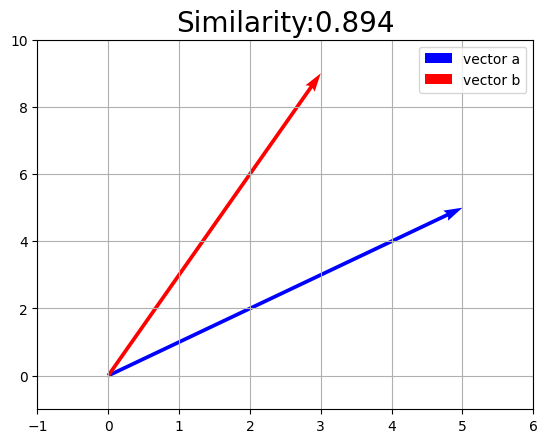

In [23]:
import matplotlib.pyplot as plt
#import seaborn as sns

# Set Seaborn theme
#sns.set_context("paper") # or "talk"
#sns.set_style("whitegrid")

# コサイン類似度を計算
sim_val = cos_similarity(a_vec, b_vec)

# 作図
plt.quiver(0, 0, a_vec[0], a_vec[1], angles='xy', scale_units='xy', scale=1, color='b', label='vector a') # 有効グラフ
plt.quiver(0, 0, b_vec[0], b_vec[1], angles='xy', scale_units='xy', scale=1, color='r', label='vector b') # 有効グラフ
plt.xlim(min(0, a_vec[0], b_vec[0]) - 1, max(0, a_vec[0], b_vec[0]) + 1)
plt.ylim(min(0, a_vec[1], b_vec[1]) - 1, max(0, a_vec[1], b_vec[1]) + 1)
plt.legend() 
plt.grid() 
plt.title('Similarity:' + str(np.round(sim_val, 3)), fontsize=20)
plt.show()

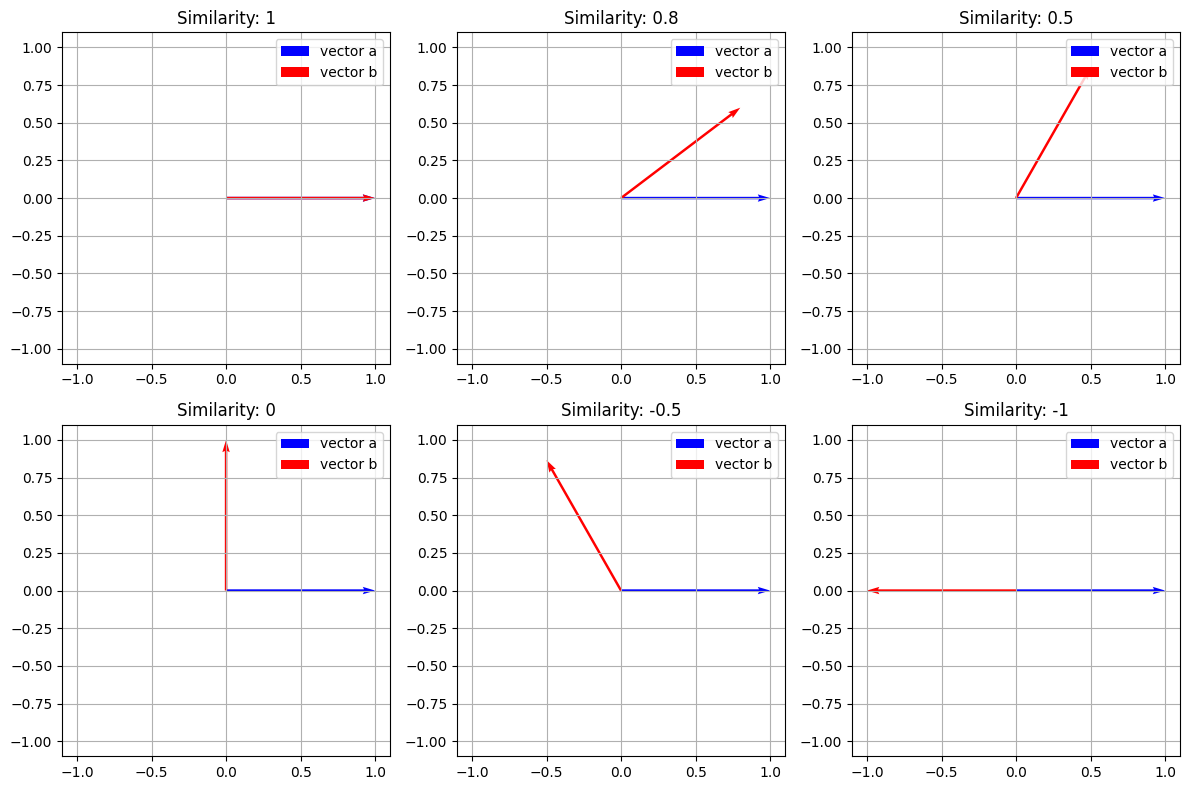

In [24]:
# Function to create a subplot for vectors with a given cosine similarity
def plot_vector_similarity(ax, similarity, vector_a):
    # Generate vector b based on desired cosine similarity and vector a
    angle = np.arccos(similarity)
    vector_b = np.array([np.cos(angle), np.sin(angle)]) * np.linalg.norm(vector_a)
    
    # Plotting the vectors
    ax.quiver(0, 0, vector_a[0], vector_a[1], angles='xy', scale_units='xy', scale=1, color='b', label='vector a')
    ax.quiver(0, 0, vector_b[0], vector_b[1], angles='xy', scale_units='xy', scale=1, color='r', label='vector b')
    
    # Setting the limits of the plot
    lim = np.max(np.abs(np.array([vector_a, vector_b]))) + 0.1
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    
    # Adding grid, legend, and title to the subplot
    ax.legend()
    ax.grid(True)
    ax.set_title('Similarity: ' + str(similarity))

# Initial vector a
a_vec = np.array([1, 0])

# Similarity values to plot
similarities = [1, 0.8, 0.5, 0, -0.5, -1]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten axes array for easy iteration
axes_flat = axes.flatten()

# Plot each similarity in a subplot
for ax, sim in zip(axes_flat, similarities):
    plot_vector_similarity(ax, sim, a_vec)

plt.tight_layout()
plt.show()

#### 単語間の類似度

前項で作成した各単語ベクトルを用いて、2つの単語の類似度を測りましょう。

比較したい2つの単語を指定して、単語ベクトルからコサイン類似度を計算します。



In [25]:
# テキストを設定
text = 'You say goodbye and I say hello.'

# 単語と単語IDに関する変数を取得
corpus, word_to_id, id_to_word = preprocess(text)

# 単語の種類数を取得
vocab_size = len(word_to_id)

# 共起行列を作成
word_matrix = create_co_matrix(corpus, vocab_size, window_size=1)

# 単語を指定して単語ベクトルを取得
c0 = word_matrix[word_to_id['you']]
c1 = word_matrix[word_to_id['i']]
print(c0)
print(c1)

# コサイン類似度を計算
sim_val = cos_similarity(c0, c1)
print(sim_val)

[0 1 0 0 0 0 0]
[0 1 0 1 0 0 0]
0.7071067691154799


#### 類似度のランキングを表示

単語の「意味」を分析する際には、ある単語に対して類似した単語を探すことがよく挙げられます。ここでは、指定した単語との類似度が高い単語を調べる関数を実装します。

In [26]:
# 対象とする単語を指定
query = 'you'

# 指定した単語のIDを取得
query_id = word_to_id[query]
print(f"指定した単語のID:{query_id}")

# 指定した単語のベクトルを取得
query_vec = word_matrix[query_id]
print(f"指定した単語のベクトル: {query_vec}")

# コサイン類似度の記録リストを初期化
vocab_size = len(id_to_word)
similarity = np.zeros(vocab_size)

# 各単語コサイン類似度を計算
for i in range(vocab_size):
    similarity[i] = cos_similarity(word_matrix[i], query_vec)

# 値を表示
print("類似度の結果：")
for i,j in zip(list(word_to_id.keys()),np.round(similarity, 5)):
    print(f"{i}:{j}")

指定した単語のID:0
指定した単語のベクトル: [0 1 0 0 0 0 0]
類似度の結果：
you:1.0
say:0.0
goodbye:0.70711
and:0.0
i:0.70711
hello:0.70711
.:0.0


```{checkitout} argsortメソッド
 ``.argsort()``メソッドは、配列の要素の値が小さい順にインデックスを返します。ここで知りたいのは上位のインデックスのため、similarityに-1を掛けて符号を反転させることで、大小関係を逆転させます。

```

In [27]:
# 配列を作成
arr = np.array([0, 20, 10, 40, 30])
print(arr)

# 低い順のインデックス
print(arr.argsort())

# 大小関係を逆転
print(-1 * arr)

# 高い順のインデックス
print((-1 * arr).argsort())

[ 0 20 10 40 30]
[0 2 1 4 3]
[  0 -20 -10 -40 -30]
[3 4 1 2 0]


In [28]:
# 表示する順位を指定
top = 5

# 類似度上位の単語と値を表示
count = 0 # 表示回数を初期化
for i in (-1 * similarity).argsort():
    
    # 指定した単語のときは次の単語に移る
    if id_to_word[i] == query:
        continue
    
    # 単語と値を表示
    print(' %s: %s' % (id_to_word[i], similarity[i]))
    
    # 指定した回数に達したら処理を終了
    count += 1 # 表示回数を加算
    if count >= top:
        break

 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


In [29]:
# 類似度の上位単語を検索関数の実装
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    
    # 指定した単語がテキストに含まれないとき
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    
    # 対象の単語を表示
    print('\n[query] ' + query)
    
    # 指定した単語のIDを取得
    query_id = word_to_id[query]
    
    # 指定した単語のベクトルを取得
    query_vec = word_matrix[query_id]
    
    # コサイン類似度を計算
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    # 類似度上位の単語と値を表示
    count = 0 # 表示回数を初期化
    for i in (-1 * similarity).argsort():
        
        # 指定した単語のときは次の単語に移る
        if id_to_word[i] == query:
            continue
        
        # 単語と値を表示
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        # 指定した回数に達したら処理を終了
        count += 1 # 表示回数を加算
        if count >= top:
            return

In [30]:
# クエリを指定
query = 'you'

# 類似の単語を表示
most_similar(query, word_to_id, id_to_word, word_matrix, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## カウントベースの手法の改善

```{checkitout} 情報量の定義  
事象$x$の生起確率$p(x)$を基にして情報量$I(x)$は$I(x) = - \log_2 p(x)$になります。$0 \leq p(x) \leq 1$なので、$\log p(x)$は常に負の値になる。よって符号を反転した値を情報量とすることで、常に正の値をとるようにする。$log$の底が$2$なのは、情報学分野において0と1からなるbitとの相性からよく使われるためである。
```

### 相互情報量

ここまでは単語がテキストに出現する頻度そのままを扱いましたが、このやり方によって単語分散を計測する際、高頻度単語によるバイアスは生じる可能性があります。

例えば、日本語において、「の」は非常に一般的な助詞で、さまざまな文脈で使用されます。単語の共起行列を作成するとき、「の」は非常に頻繁に出現し、多くの異なる単語とペアを形成するため、単純な共起頻度はその単語の意味のある関連性を捉えるのには不十分です。

そのような問題を解決するために、相互情報量(Pointwise Mutual Information)と呼ばれる指標が使われます。

2つの単語$x$,$y$の出現確率をそれぞれ$P(x)$,$P(y)$とします。$x$の出現確率は

$$
P(x)
    = \frac{C(x)}{N}
$$

で計算します。ここで$C(x)$は単語$x$が(テキストではなく)コーパス(共起行列)にカウントされた回数、$N$はコーパスの総単語数とします。

また単語$x$,$y$が共起(ウィンドウサイズ内で続けて出現)した回数を$C(x,y)$とします。

$$
P(x, y)
    = \frac{C(x, y)}{N}
$$

これを用いて、単語$x$,$y$の相互情報量(PMI)は次のように定義されます。

$$
\mathrm{PMI}(x, y)
    = \log_2 \frac{
          P(x, y)
      }{
          P(x) P(y)
      }
$$

またこの式は、次のように変形することで

$$
\begin{align}
\mathrm{PMI}(x, y)
   &= \log_2 \left(
          P(x, y)
          \frac{1}{P(x)}
          \frac{1}{P(y)}
      \right)
\\
   &= \log_2 \left( 
          \frac{C(x, y)}{N}
          \frac{N}{C(x)}
          \frac{N}{C(y)}
      \right)
\\
   &= \log_2 \frac{
          C(x, y) N
      }{
          C(x) C(y)
      }
\end{align}
$$

出現回数と総単語数から直接で計算できることが分かります。

ただし出現回数が0のときに不都合が生じるため、次の正の相互情報量(PPMI)を用います。

$$
\mathrm{PPMI}(x, y)
    = \max(0, \mathrm{PMI}(x, y))
$$



In [31]:
from tqdm.notebook import tqdm
# 相互情報量行列の作成関数の実装
def ppmi(C, verbose=False, eps=1e-8):
    
    # PPMI行列の受け皿を作成
    M = np.zeros_like(C, dtype=np.float32)
    
    # PPMIに用いる値を計算
    N = np.sum(C) # 総単語数
    S = np.sum(C, axis=0) # 各単語の出現回数
    
    # 進行状況確認用の値を計算
    total = C.shape[0] * C.shape[1]
    cnt = 0 # 処理回数を初期化
    
    # 1語ずつ正の相互情報量を計算
    for i in tqdm(range(C.shape[0])): # 各行
        for j in range(C.shape[1]): # 各列
            
            # PPMIを計算
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)
    
    return M

In [32]:
# 共起行列を作成
C = create_co_matrix(corpus, vocab_size, window_size=1)
print(C)

W = ppmi(C, verbose=True)


# 正の相互情報量行列
print(np.round(W, 2))

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


  0%|          | 0/7 [00:00<?, ?it/s]

[[0.   1.81 0.   0.   0.   0.   0.  ]
 [1.81 0.   0.81 0.   0.81 0.81 0.  ]
 [0.   0.81 0.   1.81 0.   0.   0.  ]
 [0.   0.   1.81 0.   1.81 0.   0.  ]
 [0.   0.81 0.   1.81 0.   0.   0.  ]
 [0.   0.81 0.   0.   0.   0.   2.81]
 [0.   0.   0.   0.   0.   2.81 0.  ]]


### 次元削減

次元削減は、ベクトルの次元を重要な情報を保持しながら削減する手法を指します。

#### SVD

次元削減を行う方法はいくつかあります。ここでは特異値分解(Singular Value Decomposition:SVD)を使って次元削減を行います。

SVDは、任意の行列を3つの行列の積へ分解します。

$A = U\Sigma V^T$

ここで、$A$は$n \times d$の行列、$U$は$n \times n$、$V$は$d \times d$の直交行列です。


```{checkitout} 直交行列
直交行列とは、転置行列$A^T$と逆行列$A^{-1}$が等しくなる行列。直交行列の列ベクトル（または行ベクトル）は互いに直交し、かつ正規化されています（つまり、それぞれのベクトルの長さが1）。これは、直交行列が基底変換を行う際に、ベクトルの長さや角度を保持することを意味します。そのため、直交行列は主にベクトル空間の基底を変換する際や、回転や反射などの幾何学的変換を表現するのに用いられます。
```


![](./Figure/svd.png)

- $U$は何らかの空間の基底を形成しています。ここは、$U$という行列を「単語空間」として扱うことができます。

- $\Sigma$は対角行列で、この対角成分には、「特異値」というものが大きい順で並んでいます。ここで、「特異値」は対応する軸の重要度とみなすことができます。次元削減は、この情報によって重要でない要素を削除することが考えれます。

SVDによって、疎なベクトルが密なベクトルへ変換されています。この密なベクトルから、先頭の二つの要素を取り出すことで、元のベクトルの「情報」をできるだけ保持しながら次元を削減することができます。

In [33]:
U, S, V = np.linalg.svd(W)

print(C[0]) # 共起行列
print(W[0]) # PPMI行列
print(U[0]) # SVD

[0 1 0 0 0 0 0]
[0.        1.8073549 0.        0.        0.        0.        0.       ]
[ 0.0000000e+00 -3.4094876e-01 -3.8857806e-16  1.2051624e-01
  9.3232495e-01 -1.1102230e-16  3.2068993e-16]


## カウントベースの手法による単語分散の作成

In [34]:
import re
import pickle

with open("./Data/dokujo-tsushin.txt", mode="r",encoding="utf-8") as f:
    corpus = []
    for line in f:
        cleaned_line = line.replace('\u3000', '').replace('\n', '')
        if cleaned_line!="":
            corpus.append(cleaned_line)

In [35]:
corpus[:5]

['  友人代表のスピーチ、独女はどうこなしている？',
 'もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり……という「お祝い貧乏」状態の人も多いのではないだろうか？さらに出席回数を重ねていくと、こんなお願いごとをされることも少なくない。',
 '「お願いがあるんだけど……友人代表のスピーチ、やってくれないかな？」',
 'さてそんなとき、独女はどう対応したらいいか？',
 '最近だとインターネット等で検索すれば友人代表スピーチ用の例文サイトがたくさん出てくるので、それらを参考にすれば、無難なものは誰でも作成できる。しかし由利さん（33歳）はネットを参考にして作成したものの「これで本当にいいのか不安でした。一人暮らしなので聞かせて感想をいってくれる人もいないし、かといって他の友人にわざわざ聞かせるのもどうかと思うし……」ということで活用したのが、なんとインターネットの悩み相談サイトに。そこに作成したスピーチ文を掲載し「これで大丈夫か添削してください」とメッセージを送ったというのである。']

In [36]:
#!pip install mecab-python3
#!pip install unidic-lite

In [37]:
import MeCab
from tqdm.notebook import tqdm
def tokenize_with_mecab(sentences):
    # Initialize MeCab with the specified dictionary
    corpus = []
    for sentence in sentences:
        sentence = re.sub("http://news.livedoor.com/article/detail/[0-9]{7}/","", sentence) # 注2）
        sentence = re.sub("[0-9]{4}-[0-9]{2}-[0-9]{2}T[0-9]{2}:[0-9]{2}:[0-9]{2}\+[0-9]{4}","", sentence) # 注3）
        sentence = re.sub("[「」]","", sentence)
        # Parse the sentence
        node = mecab.parseToNode(sentence)
        # Iterate over all nodes
        while node:
            # Extract the surface form of the word
            word = node.surface
            # Skip empty words and add to the corpus
            if word:
                corpus.append(word)
            node = node.next
    return corpus


# Initialize the MeCab tokenizer
mecab = MeCab.Tagger()
#path = "-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd"
#mecab = MeCab.Tagger(path)
corpus = tokenize_with_mecab(corpus)

<>:8: SyntaxWarning: invalid escape sequence '\+'
<>:8: SyntaxWarning: invalid escape sequence '\+'
/var/folders/0s/grknnvt93bs7w2rbrt894wkc0000gn/T/ipykernel_13865/2217006374.py:8: SyntaxWarning: invalid escape sequence '\+'
  sentence = re.sub("[0-9]{4}-[0-9]{2}-[0-9]{2}T[0-9]{2}:[0-9]{2}:[0-9]{2}\+[0-9]{4}","", sentence) # 注3）


In [38]:
corpus[:10]

['友人', '代表', 'の', 'スピーチ', '、', '独女', 'は', 'どう', 'こなし', 'て']

In [39]:
word_to_id = {}
id_to_word = {}

for word in corpus:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word
        
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['女']:", word_to_id['女'])
print("word_to_id['結婚']:", word_to_id['結婚'])
print("word_to_id['夫']:", word_to_id['夫'])

id_to_word[0]: 友人
id_to_word[1]: 代表
id_to_word[2]: の

word_to_id['女']: 3163
word_to_id['結婚']: 148
word_to_id['夫']: 1426


In [40]:
# リストに変換
corpus = [word_to_id[word] for word in corpus]

# NumPy配列に変換
corpus = np.array(corpus)

In [41]:
vocab_size=len(word_to_id)
vocab_size

25547

In [42]:
window_size = 2
wordvec_size = 100
vocab_size = len(word_to_id)

In [43]:
C=create_co_matrix(corpus,vocab_size,window_size=window_size)

In [44]:
#W = ppmi(C)
#np.save('./Data/W.npy', W)
W = np.load('./Data/W.npy')

In [45]:
from sklearn.utils.extmath import randomized_svd
U, S, V= randomized_svd(W,n_components=wordvec_size,n_iter=5,random_state=None)

In [46]:
word_vecs=U[:, :wordvec_size]

In [47]:
querys = ['女', '結婚', '彼女', "秋"]

for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] 女
 デブ: 0.7226879000663757
 頼りがい: 0.7069697380065918
 技: 0.7065211534500122
 結ば: 0.6929681897163391
 市民: 0.683417797088623

[query] 結婚
 縁組: 0.7332433462142944
 正子: 0.6813077926635742
 切迫: 0.6812717318534851
 久仁子: 0.6402035355567932
 後押し: 0.6352586150169373

[query] 彼女
 土地: 0.8677912950515747
 つかわ: 0.8450607657432556
 ソテー: 0.8422375917434692
 強がり: 0.8376142382621765
 まね: 0.8207266330718994

[query] 秋
 館: 0.514491081237793
 おわ: 0.5090659856796265
 切らさ: 0.4935395121574402
 食後: 0.4698116183280945
 交渉: 0.4658271074295044


### おまけ：Pytorchでの実装

In [48]:
import torch
torch.backends.mps.is_available()

def ppmi_torch(C, eps=1e-8):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    C = torch.tensor(C, dtype=torch.float32, device=device)
    
    # 総単語数と各単語の出現頻度を計算
    N = torch.sum(C)
    S = torch.sum(C, dim=0, keepdim=True)  # 各単語の出現回数（列方向）
    
    # PPMIの計算（ループなし）
    pmi = torch.log2(C * N / (S.t() * S) + eps)  # PMI行列を一括計算
    M = torch.max(pmi, torch.tensor(0.0, device=device))  # PPMI行列を計算
    
    return M  # 必要であればCPUに戻す

In [49]:
W = ppmi_torch(C)

In [50]:
from sklearn.utils.extmath import randomized_svd
U, S, V= randomized_svd(W.cpu().numpy(),n_components=wordvec_size,n_iter=5,random_state=None)

In [51]:
word_vecs=U[:, :wordvec_size]

In [52]:
querys = ['女', '結婚', '彼女', "秋"]

for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] 女
 男: 0.7777467966079712
 男子: 0.5937835574150085
 独女: 0.5688649415969849
 男性: 0.5374248027801514
 女性: 0.5247462391853333

[query] 結婚
 離婚: 0.6396859288215637
 交際: 0.5854832530021667
 迎え: 0.5492004156112671
 入籍: 0.5393035411834717
 出産: 0.5391035676002502

[query] 彼女
 彼: 0.7317190170288086
 娘: 0.610599935054779
 夫: 0.6025635600090027
 友人: 0.6021445989608765
 母親: 0.5997404456138611

[query] 秋
 春: 0.7465042471885681
 夏: 0.7199810743331909
 冬: 0.6601986289024353
 フェス: 0.659843921661377
 季節: 0.6529552936553955
